In [1]:
from barnes_hut import *

### Galaxy (cluster) function

In [2]:
def make_exponential_disk(
    n_total: int = 400,
    R_d: float = 8.0,
    R_max: float = 40.0,
    M_total: float = 400.0,
    G_used: float = 0.1,
    bulge_frac: float = 0.15,
    bulge_sigma: float = 2.0,
    rot_sign: int = +1,
    v_disp: float = 0.05,
    seed: int = 7,
) -> list[Point]:
    """
    Galaxy-like ICs: exponential disk (Σ∝e^{-r/R_d}) + small Gaussian bulge.
    - Samples disk radii via Erlang k=2 trick (r = R_d*(E1+E2)).
    - Sets approximate circular velocities from M(<r) of disk+bulge.
    - Adds a tiny velocity dispersion to keep it from being perfectly cold.
    """
    import numpy as np
    rng = np.random.default_rng(seed)
    n_bulge = int(bulge_frac * n_total)
    n_disk  = n_total - n_bulge
    m = M_total / n_total
    pts: list[Point] = []

    # Bulge (2D Gaussian)
    if n_bulge > 0:
        xb = rng.normal(0.0, bulge_sigma, size=n_bulge)
        yb = rng.normal(0.0, bulge_sigma, size=n_bulge)
        vxb = rng.normal(0.0, v_disp, size=n_bulge)
        vyb = rng.normal(0.0, v_disp, size=n_bulge)
        for i in range(n_bulge):
            pts.append(Point(float(xb[i]), float(yb[i]), mass=m,
                             vx=float(vxb[i]), vy=float(vyb[i])))

    # Disk (Σ ∝ e^{-r/Rd} → p(r) ∝ r e^{-r/Rd}; sample with Erlang k=2)
    e1 = rng.exponential(1.0, size=n_disk)
    e2 = rng.exponential(1.0, size=n_disk)
    r = R_d * (e1 + e2)
    r = np.clip(r, 0.0, R_max)
    th = rng.uniform(0, 2*np.pi, size=n_disk)
    xd, yd = r*np.cos(th), r*np.sin(th)

    # Approx enclosed mass: disk + cored bulge
    M_disk  = M_total * (1.0 - bulge_frac)
    M_bulge = M_total * bulge_frac
    a = 2.5 * bulge_sigma + 1e-6
    M_enc = M_disk * (1.0 - np.exp(-r/R_d)*(1.0 + r/R_d)) + M_bulge * (r**2/(r**2 + a**2))

    # Circular speed (avoid div-by-zero near center)
    v_c = np.sqrt(np.maximum(0.0, G_used * M_enc / np.maximum(r, 0.5)))

    # Tangential directions
    tx, ty = rot_sign * (-np.sin(th)), rot_sign * (np.cos(th))
    vxd = v_c * tx + rng.normal(0.0, v_disp, size=n_disk)
    vyd = v_c * ty + rng.normal(0.0, v_disp, size=n_disk)

    for i in range(n_disk):
        pts.append(Point(float(xd[i]), float(yd[i]), mass=m,
                         vx=float(vxd[i]), vy=float(vyd[i])))
    return pts


In [ ]:
G_sim = 0.1
pts = make_exponential_disk(
    n_total=360,
    R_d=7.0,
    R_max=35.0,
    M_total=360.0,
    G_used=G_sim,
    bulge_frac=0.18,
    bulge_sigma=2.0,
    rot_sign=+1,    # flip to -1 for clockwise
    v_disp=0.08,
    seed=42,
)

barnes_hut_sim(
    pts,
    dt=0.06,
    G=G_sim,
    theta=0.6,
    eps=0.15,
    capacity=1,
    max_depth=32,
    n_frames=640,            # bump up for longer runs
    draw_quadtree=False,
    fixed_viewport=(-45, 45, -45, 45),
    # save_to_video="./Outputs/Barnes-Hut/ep2.mp4",      # set e.g. "/mnt/data/galaxy.mp4" if cv2 is available
    video_fps=30
)

print("Final KE:", kinetic_energy(pts), "Total momentum:", total_momentum(pts))


## Increasing number of Starts (a.k.a `Point` object)

n = 9600

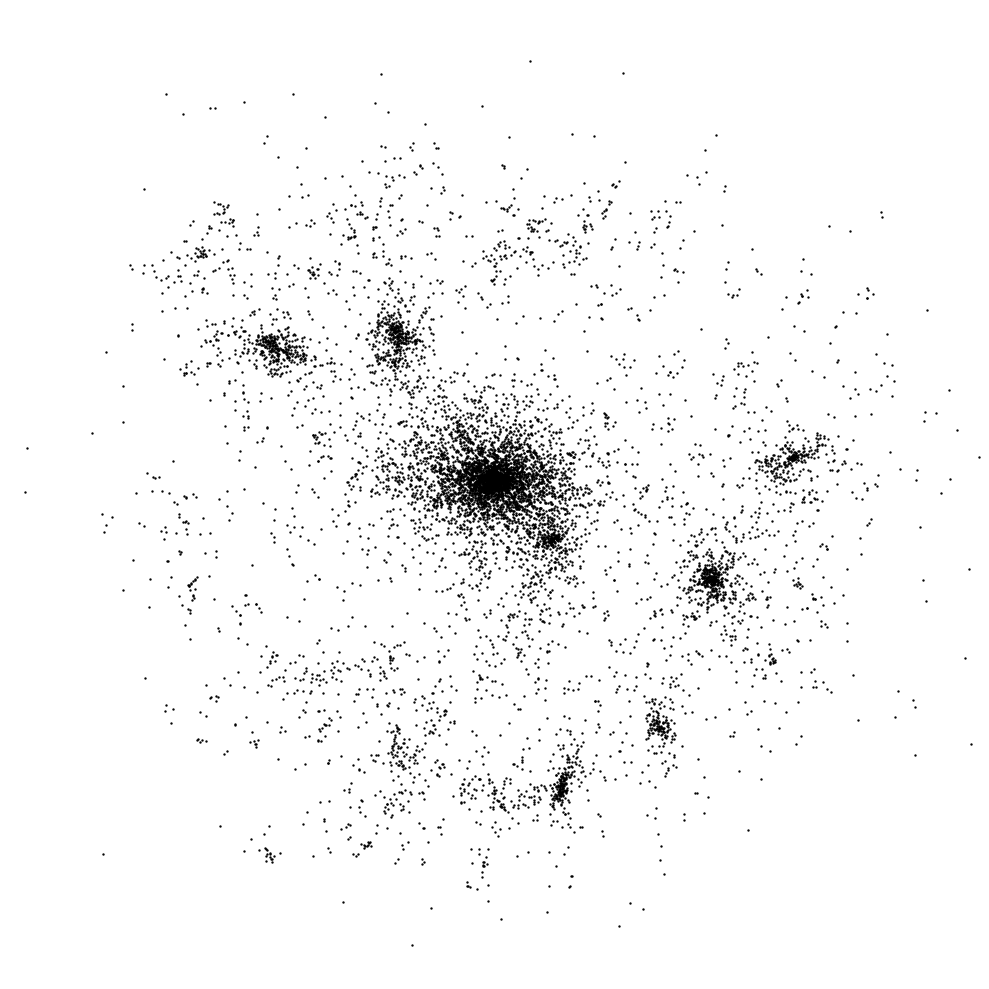

Frame: 700/700


In [5]:
G_sim = 0.1
pts = make_exponential_disk(
    n_total=9600,
    R_d=7.0,
    R_max=35.0,
    M_total=360.0,
    G_used=G_sim,
    bulge_frac=0.18,
    bulge_sigma=2.0,
    rot_sign=+1,    # flip to -1 for clockwise
    v_disp=0.08,
    seed=42,
)


barnes_hut_sim(
    pts,
    dt=0.08,           # larger step for speed
    G=0.1,
    theta=1.0,         # most aggressive approximation
    eps=0.35,          # see rule-of-thumb below
    capacity=16,       # chunkier leaves => shallower tree
    max_depth=24,
    n_frames=700,
    draw_quadtree=False,
    fixed_viewport=(-45,45,-45,45),
    save_to_video="./Outputs/Barnes-Hut/3600.mp4",
    video_fps=30,
    point_size=0.5,
    point_color='black'
)
